### 2. MNIST CNN

이번엔 학습해볼 데이터를 바꿔볼게요.
MNIST라는 0부터 9까지의 손글씨를 담고 있는 데이터셋이에요.  
우리가 이번에 해볼 것은 Linear Regression이 아니라, Neural Network를 한번 만들어 볼거에요. Neural Network는 앞서 ppt 자료에서 설명한것 과 같이 우리의 신경 구조를 모방해서 만들어낸 구조에요.

저희는 그 중에서 Convolutional Neural Network라고 컴퓨터 비젼분야에서 굉장히 많이 쓰이는 방식을 이용해 볼거에요. 해석해보면 '합성곱 신경망' 인데, 간단히 행렬곱을 통해서 이미지에 통과하는 필터를 학습시키는 머신러닝 알고리즘입니다. 자세한건 방학때 알아보도록 해요.

PyTorch의 torchvision에서는 MNIST 데이터를 쉽게 다운로드할 수 있도록 제공해요.

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

mnist_train = dsets.MNIST(root="dataset/MNIST_data/",
                          train=True,
                          transform=transforms.ToTensor(), 
                          download=True)
mnist_test = dsets.MNIST(root="dataset/MNIST_data/",
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

plt.imshow(mnist_test.test_data[0].view(28, 28), cmap='Greys', interpolation='nearest')

Extracting dataset/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST_data/MNIST/raw


Extracting dataset/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST_data/MNIST/raw



Extracting dataset/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST_data/MNIST/raw


Extracting dataset/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST_data/MNIST/raw
Processing...
Done!



/home/fylsunghwan/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


자, 그럼 이 이미지를 학습하기 위해선 새로운 모델을 만들어볼게요.  
위에서 언급한 Convolutional Neural Network (합성 곱 신경망) 이라고 불리는 것을 활용해볼건데요, 이에 대한 자세한 내용은 방학때 알아보도록 하죠. 지금은 '이러이러한 모델'을 만들었는데, forward 함수에서 A 데이터를 이 레이어들을 거쳐서 B라는 값이 나오는구나! 정도만 아시면 될 것 같습니다.

In [2]:
import torch
import torch.nn as nn

class CNN(nn.Module): # 모델에 대한 내용은 방학때 자세히 알아보도록 해요.
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1)
        )
        self.l1after = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        )
        self.l2after = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 앞에서 본 fully-connected 레이어네요!
        self.fc1 = nn.Linear(3136, 128, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)        
    
    def forward(self, x):
        out = self.l1after(self.layer1(x))
        out = self.l2after(self.layer2(out))
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out 
    
    # 이 아래는 각 레이어가 무슨 역할을 하는지 알아보기 위해 만들었어요.
    def firstconv(self, x):
        return self.layer1(x)
    
    def secondconv(self, x):
        out = self.l1after(self.layer1(x))
        out = self.layer2(out)
        return out

PyTorch에서는 데이터셋을 다룰 때 굉장히 편리한 것이 있습니다.  
바로 데이터를 불러올 때 사용하는 데이터로더를 제공한다는 점인데요,  
이 데이터로더는 데이터를 무작위로 섞기도 하고, 배치들을 묶어서 더 빠른 속도로 학습을 할 수 있도록 도와줘요.

In [3]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                         batch_size=64,
                                         shuffle=True,
                                         drop_last=True) # 데이터를 불러오기 위한 데이터로더입니다!

PyTorch에서는 NVIDIA의 GPU를 연구용으로 사용하도록 해주는 CUDA를 정식으로 지원한압니다. CUDA는 다음과 같이 불러올 수 있습니다.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # gpu를 사용한다면 장치를 gpu로 바꾸어줍시다.
print('지금 사용하고 있는 장치는',device,'입니다.')

지금 사용하고 있는 장치는 cuda 입니다.


Convolutional Neural Network에서도 loss function으로는 CrossEntropy Loss를 사용합니다! 하지만 여기선 SGD 말고 특별한 optimizer를 사용해볼게요. Adam Optimizer는 SGD의 단점들을 보완하여서 더 빠르게 수렴하도록 만든 optimizer에요. 이에 대한 자세한 내용도 방학때 다루어보도록 해요.

In [5]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device) #여기서는 Cross Entropy라는것을 loss function으로 사용합니다!
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

본격적으로 학습을 진행해보도록 할게요.

In [6]:
import numpy as np
def print_acc():
    with torch.no_grad():
        X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
        Y_test = mnist_test.targets.to(device)

        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        print('Accuracy: ',accuracy.item()*100,"%")
        
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def firstlayer():
    test_image = mnist_test.test_data[0].view(1,1,28, 28).to(device).float()
    firstconv = model.firstconv(test_image)[0].cpu().detach().numpy()

    plot_x = 6
    plot_y = 5

    img = test_image.cpu().detach().numpy()
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('First Convolution Layer')
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(firstconv[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

    plt.imshow(deprocess_image(firstconv)[0], cmap='gray')

def secondlayer():
    plot_x = 6
    plot_y = 5
    test_image = mnist_test.test_data[0].view(1,1,28, 28).to(device).float()
    secondconv = model.secondconv(test_image)[0].cpu().detach().numpy()
    img = test_image.cpu().detach().numpy()
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Second Convolution Layer')
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(secondconv[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

    plt.imshow(deprocess_image(secondconv)[0], cmap='gray')

print_acc()

Accuracy:  11.939999461174011 %


학습이 시작되었습니다.
Epoch:01 loss = 0.15176504850387573
Epoch:02 loss = 0.04522813484072685
Epoch:03 loss = 0.03054935485124588
Epoch:04 loss = 0.02154177613556385
Epoch:05 loss = 0.01670049875974655
Epoch:06 loss = 0.013092780485749245
Epoch:07 loss = 0.010653307661414146
Epoch:08 loss = 0.008842968381941319
Epoch:09 loss = 0.007707865443080664
Epoch:10 loss = 0.007375629618763924
Epoch:11 loss = 0.005095234606415033
Epoch:12 loss = 0.006124669220298529
Epoch:13 loss = 0.00417731748893857
Epoch:14 loss = 0.0050466954708099365
Epoch:15 loss = 0.0037704301066696644
학습이 종료되었습니다.


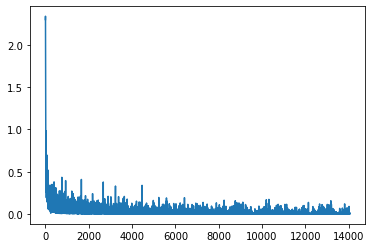

In [7]:
total_batch = len(data_loader)
losses = []
epochs = 15
print('학습이 시작되었습니다.')

for epoch in range(epochs):
    avg_loss=0
    for X_data, Y_data in data_loader:
        X_data = X_data.to(device)
        Y_data = Y_data.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X_data)
        
        loss = criterion(hypothesis, Y_data)
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        avg_loss += loss/total_batch
    print('Epoch:{:02d} loss = {}'.format(epoch+1, avg_loss))
print('학습이 종료되었습니다.')
plt.plot(losses)
    

Accuracy:  98.70999455451965 %


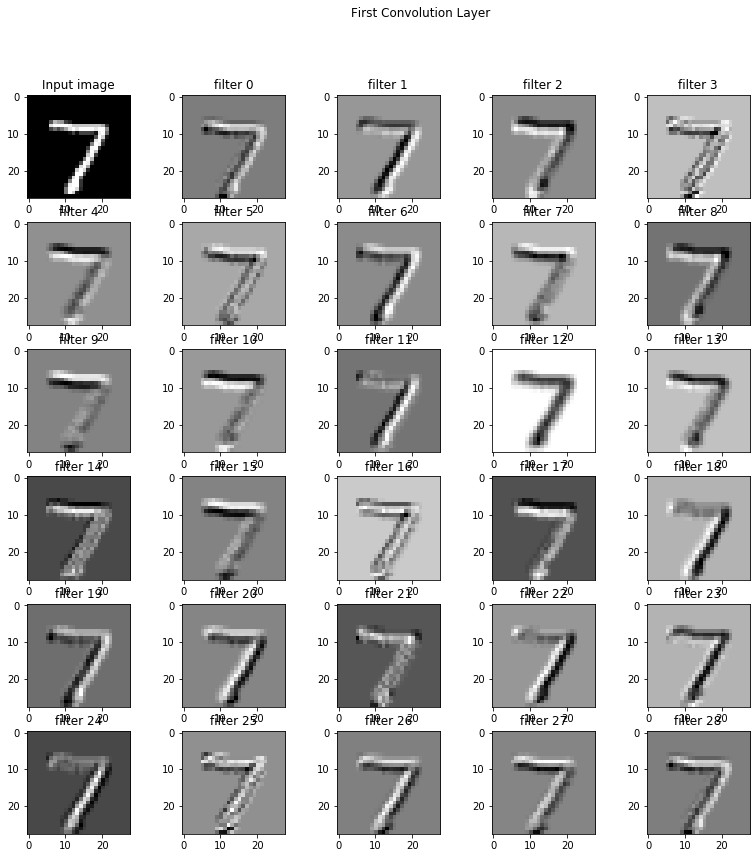

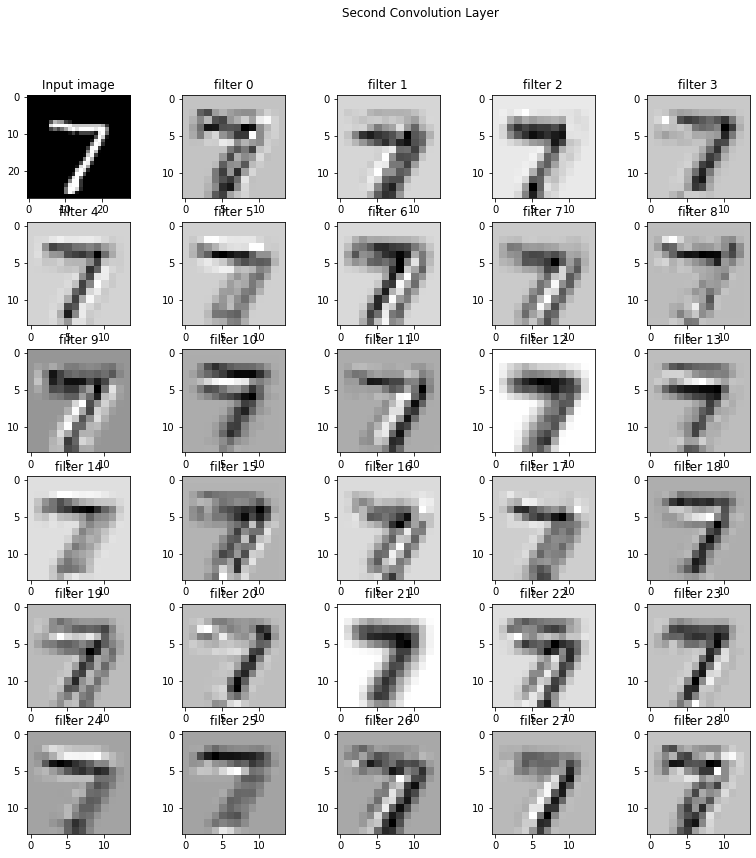

In [8]:
print_acc()
firstlayer()
secondlayer()